In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.svm import SVR
from itertools import product

In [2]:
parameter_space = {'n_estimators':[2,200],
                  'max_depth':[2,40],
                  'min_samples_split':[2,100],
                  'min_samples_leaf':[2,200],
                  }
  

In [3]:
class Minesweeper:
    def __init__(self, parameter_space):
        self.b = 3
        self.df = pd.DataFrame(columns=parameter_space.keys())
        self.df['score'] = []
        self.mms = MMS().fit(pd.DataFrame(parameter_space))
        self.dimensions = len(parameter_space)
        
    @property
    def bins(self):
        return np.linspace(0,1,self.b+1)
    
    def get_parameters(self):
        scores = self.df.pop('score')
        while True:
            all_cells = set(product(list(range(self.b)), repeat=self.dimensions))
            occupied_cells = list(set(self.df.apply(lambda x:np.digitize(x, self.bins)-1, 
                                           result_type='reduce', axis =1).apply(tuple)))
        
            relative_neighbors = (list(product((-1,0,1), repeat=self.dimensions)))
            exclude_cells = list(set([(tuple([i+j for i,j in zip(a,b)])) for b in relative_neighbors for a in occupied_cells]))
            exclude_cells = set([x for x in exclude_cells if all(0<=i<self.b for i in x)])
        
            vacant_cells = list(all_cells-exclude_cells)
            if len(vacant_cells)==0:
                self.b+=1
                continue
                
            chosen_cell = vacant_cells[np.random.randint(0,len(vacant_cells))]
            chosen_values = tuple([(self.bins[i]+self.bins[i+1])/2 for i in chosen_cell])
            self.df['score']=scores
            return {k:v for k,v in zip(self.mms.feature_names_in_,
                                       self.mms.inverse_transform([chosen_values])[0])}
        
    def update_values(self,values,score):
        values = pd.DataFrame(values, index=[0])
        values = pd.DataFrame(data=self.mms.transform(values), columns=values.columns)
        values['score'] = score
        
        self.df = pd.concat([self.df, values], ignore_index=True).reset_index(drop=True)
        
        
    def best_parameters(self):
        if len(self.df)<2: return self.get_parameters()
        X = self.df.sample(frac=1/np.e)
        y = X.pop('score')
        svr = SVR().fit(X,y)
        predict_X = pd.DataFrame(columns=X.columns, data=np.random.uniform(size=(40,X.shape[1])))
        predictions = svr.predict(predict_X)
        return {k:v for k,v in zip(self.mms.feature_names_in_, 
                                   self.mms.inverse_transform([predict_X.loc[predictions.argmax()]]).flatten())}

In [4]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
X_train, X_test, y_train, y_test = train_test_split(*make_classification(n_samples=10000,n_features=200))

In [5]:
ms = Minesweeper(parameter_space)

In [15]:
for i in range(30):
    if i%3==1:
        values = ms.best_parameters()
    else:
        values = ms.get_parameters()
    values = {k:int(v) for k,v in values.items()}
    print(values)
    rfc = RFC(**values).fit(X_train,y_train)
    score = f1_score(y_test, rfc.predict(X_test))
    print(score)
    ms.update_values(values, score)
ms.df

{'n_estimators': 180, 'max_depth': 5, 'min_samples_split': 70, 'min_samples_leaf': 100}
0.8696330991412958
{'n_estimators': 38, 'max_depth': 31, 'min_samples_split': 24, 'min_samples_leaf': 3}
0.8715922560252866
{'n_estimators': 21, 'max_depth': 21, 'min_samples_split': 51, 'min_samples_leaf': 140}
0.8671601090767433
{'n_estimators': 140, 'max_depth': 21, 'min_samples_split': 31, 'min_samples_leaf': 61}
0.8696337140606538
{'n_estimators': 71, 'max_depth': 39, 'min_samples_split': 57, 'min_samples_leaf': 27}
0.8697711128650356
{'n_estimators': 140, 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 180}
0.8693586698337292
{'n_estimators': 61, 'max_depth': 21, 'min_samples_split': 90, 'min_samples_leaf': 140}
0.8677912907022363
{'n_estimators': 2, 'max_depth': 26, 'min_samples_split': 39, 'min_samples_leaf': 150}
0.8434579439252337
{'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 100}
0.8684003152088258
{'n_estimators': 100, 'max_depth': 36, '

,n_estimators,max_depth,min_samples_split,min_samples_leaf,score
0,0.166667,0.157895,0.163265,0.828283,0.870150
1,0.166667,0.157895,0.826531,0.166667,0.866929
2,0.828283,0.500000,0.826531,0.828283,0.869258
3,0.166667,0.815789,0.826531,0.828283,0.867166
4,0.828283,0.815789,0.163265,0.494949,0.870866
5,0.828283,0.157895,0.163265,0.494949,0.867895
6,0.166667,0.815789,0.500000,0.166667,0.870635
7,0.166667,0.157895,0.826531,0.828283,0.863975
8,0.166667,0.815789,0.163265,0.828283,0.862987
9,0.828283,0.157895,0.826531,0.166667,0.867160


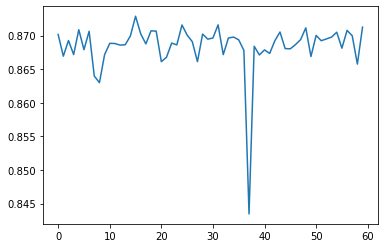

In [18]:
plt.plot(ms.df.index, ms.df['score']);

In [20]:
ms.df.sort_values('score',ascending=False)

,n_estimators,max_depth,min_samples_split,min_samples_leaf,score
15,0.227273,0.684211,0.755102,0.010101,0.872871
31,0.181818,0.763158,0.224490,0.005051,0.871592
24,0.237374,0.052632,0.306122,0.126263,0.871571
59,0.747475,0.394737,0.581633,0.247475,0.871248
48,0.898990,0.500000,0.897959,0.494949,0.871146
4,0.828283,0.815789,0.163265,0.494949,0.870866
56,0.414141,0.394737,0.408163,0.080808,0.870764
18,0.616162,0.921053,0.540816,0.050505,0.870700
19,0.464646,0.842105,0.734694,0.934343,0.870662
6,0.166667,0.815789,0.500000,0.166667,0.870635
